In [83]:
######## MODULES ##########
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import celia_functions as cf
plt.rcParams.update({'font.size':14, "xtick.direction":"in", "ytick.direction":"in"})
pd.set_option('display.max_rows', 50)
#np.set_printoptions(threshold=sys.maxsize)

In [84]:
shotsheet = cf.read_metadata(["SHOT #","Target X","Target Z","TARGET NUMBER","Laser Energy (before comp) [J]"])
targetsheet = cf.read_metadata(["Number","Wheel","Thickness (um)","Length(mm)","Material","Type"])

shotsheet = pd.DataFrame(shotsheet)
targetsheet = pd.DataFrame(targetsheet)

to_numeric = lambda series: pd.to_numeric(series, errors= "coerce") # pd.to_numeric works on pd.series but not on pd.DataFrames
shotsheet = shotsheet.apply(to_numeric) 
shotsheet.dropna(how= "all", inplace= True) # last row has no data! Remove it.

shotsheet = shotsheet.merge(targetsheet, how= "left", left_on= "TARGET NUMBER", right_on= "Number") # merge the targetsheet with the shotsheet

shotsheet.describe()

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Number,Wheel,Thickness (um),Length(mm)
count,266.000000,234.000000,234.000000,266.000000,201.000000,266.000000,266.000000,266.000000,266.000000
mean,132.661654,3.552863,6.181303,68.000000,0.884909,68.000000,4.409774,264.097744,8.300752
std,76.697139,1.382375,0.950730,37.500893,0.173772,37.500893,1.806001,397.911451,1.228498
min,1.000000,0.705000,3.195000,1.000000,0.091800,1.000000,1.000000,25.000000,4.000000
25%,66.250000,2.475000,5.590000,33.750000,0.827000,33.750000,3.000000,50.000000,8.000000
50%,132.500000,3.395000,6.170000,69.000000,0.873000,69.000000,4.000000,50.000000,8.000000
75%,198.750000,4.511250,6.790000,104.750000,0.953000,104.750000,6.000000,50.000000,8.000000
max,265.000000,6.985000,8.815000,125.000000,1.800000,125.000000,7.000000,1000.000000,10.000000


In [85]:
shotsheet["relative X"] = shotsheet.groupby('Number')['Target X'].transform(lambda x: x -x.iloc[0]) #calculate the relitive movement from the first shot.
shotsheet["relative Z"] = shotsheet.groupby('Number')['Target Z'].transform(lambda x: x -x.iloc[0])
shotsheet["nth shot on target"] = shotsheet.groupby('Number')["Number"].transform(lambda series: np.arange(len(series)) +1) #add a column that counts how many times the target has been shot.

shotsheet["d"] = np.linalg.norm(shotsheet[["relative X", "relative Z"]], axis= 1) # pythagorus to find d. This might be a little simplistic since we know the angle should be 25°

# Apply filters
shotsheet = shotsheet[shotsheet["Type"] == "wire"]
shotsheet = shotsheet[shotsheet["Material"] == "Cu"]
shotsheet = shotsheet[shotsheet["Length(mm)"] == 8]
shotsheet = shotsheet[shotsheet["nth shot on target"] == 1]

shotsheet.describe()

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Number,Wheel,Thickness (um),Length(mm),relative X,relative Z,nth shot on target,d
count,33.000000,33.000000,33.000000,33.000000,26.000000,33.000000,33.000000,33.0,33.0,33.0,33.0,33.0,33.0
mean,140.515152,2.009242,5.182303,74.212121,0.883462,74.212121,4.636364,50.0,8.0,0.0,0.0,1.0,0.0
std,67.929247,0.517446,0.770769,33.874546,0.110543,33.874546,1.673660,0.0,0.0,0.0,0.0,0.0,0.0
min,34.000000,0.795000,3.195000,16.000000,0.609000,16.000000,2.000000,50.0,8.0,0.0,0.0,1.0,0.0
25%,76.000000,1.705000,4.710000,58.000000,0.821500,58.000000,4.000000,50.0,8.0,0.0,0.0,1.0,0.0
50%,137.000000,2.065000,5.315000,81.000000,0.885500,81.000000,5.000000,50.0,8.0,0.0,0.0,1.0,0.0
75%,191.000000,2.365000,5.770000,106.000000,0.969000,106.000000,6.000000,50.0,8.0,0.0,0.0,1.0,0.0
max,254.000000,3.075000,6.520000,116.000000,1.080000,116.000000,7.000000,50.0,8.0,0.0,0.0,1.0,0.0


### Choose which targets and channels to use here!

In [86]:
pyro_background = {"Ch1": [99,100,101,102,104,105,107,108,109,110,111,112,113,154,155,156,157,158,159,160,161,162,163,164,165,166,168,169,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,214,215,216,217,218,219,220,221,222,223,224,225,226,227,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265],
                   "Ch2": [114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153],
                   "Ch3": [70,71,72,74,75,76,77,78,79,80,83,84,85,86,87,88,89,92,93,94,95,96,97,98]}

diagnostics = {"Ch3": [114,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137],
               "Ch4": [114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145],
               "bdot": [114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145],
               "xray": [114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145],
               "energy": [114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145]}

diagnostics_functions = {"Ch1": lambda x: x,
                         "Ch2": lambda x: x,
                         "Ch3": lambda x: x,
                         "Ch4": lambda x: x,
                         "bdot": lambda x: np.ma.masked_invalid(x).ptp(),
                         "tof": np.ptp,
                         "diode": np.ptp,
                         "xray": cf.estimate_xray_signal,
                         "energy": lambda x: x}

diagnostic_data = cf.read_diagnostic_data(diagnostics, functions= diagnostics_functions, silent= False)
diagnostic_data = pd.DataFrame(diagnostic_data)

background_data = cf.read_diagnostic_data(pyro_background, functions= diagnostics_functions, silent= False)
background_data = pd.DataFrame(background_data)

background_lookup = pd.DataFrame(([shot, ch, cf.flatten_list(background_data[ch][background_data["shot"] == shot].values)] for ch, shots in pyro_background.items() for shot in shots), columns= ["shot", "bg channel", "bg data"]) #Create a dataframe with the bg data


Found 23 files:
   290124WIRESHOT136000_Ch3.csv
   290124WIRESHOT128000_Ch3.csv
   290124WIRESHOT129000_Ch3.csv
   290124WIRESHOT130000_Ch3.csv
   290124WIRESHOT131000_Ch3.csv
   290124WIRESHOT132000_Ch3.csv
   290124WIRESHOT133000_Ch3.csv
   290124WIRESHOT134000_Ch3.csv
   290124WIRESHOT135000_Ch3.csv
   290124WIRESHOT122000_Ch3.csv
   290124WIRESHOT123000_Ch3.csv
   290124WIRESHOT124000_Ch3.csv
   290124WIRESHOT125000_Ch3.csv
   290124WIRESHOT126000_Ch3.csv
   290124WIRESHOT127000_Ch3.csv
   290124WIRESHOT114000_Ch3.csv
   290124WIRESHOT116000_Ch3.csv
   290124WIRESHOT117000_Ch3.csv
   290124WIRESHOT118000_Ch3.csv
   290124WIRESHOT119000_Ch3.csv
   290124WIRESHOT120000_Ch3.csv
   290124WIRESHOT121000_Ch3.csv
   290124WIRESHOT137000_Ch3.csv
Found 32 files:
   290124WIRESHOT136000_Ch4.csv
   290124WIRESHOT128000_Ch4.csv
   290124WIRESHOT129000_Ch4.csv
   290124WIRESHOT130000_Ch4.csv
   290124WIRESHOT131000_Ch4.csv
   290124WIRESHOT132000_Ch4.csv
   290124WIRESHOT133000_Ch4.csv
   29012

In [87]:
pyro_channels_to_bg_subtract = ["Ch1","Ch2","Ch3"]
pyro_channels = ["Ch1","Ch2","Ch3","Ch4"] # Establishing a catagory of diagnostics will be helpful later.

pyro_channels = np.intersect1d(pyro_channels, list(diagnostic_data.keys())) # useful to know which pyro channels to analysise and plot
pyro_channels_to_bg_subtract = np.intersect1d(pyro_channels_to_bg_subtract, list(diagnostic_data.keys())) 

diagnostic_data = diagnostic_data.merge(background_lookup, how= "left", on= "shot") # add the background infomation to the shotsheet
diagnostic_data["bg data"].fillna(0, inplace= True) # Sometimes the background was not measured

C:\Users\syf83691\AppData\Local\Temp\ipykernel_9624\2945668715.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diagnostic_data["bg data"].fillna(0, inplace= True) # Sometimes the background was not measured


In [88]:
for ch in pyro_channels_to_bg_subtract:
    diagnostic_data[ch] = diagnostic_data[ch] -diagnostic_data["bg data"]

diagnostic_data.drop("bg data", axis= 1, inplace= True) # The background data is no longer needed now that we have finished background subtraction.

diagnostic_data.describe()

,shot,bdot,xray,energy
count,32.000000,30.000000,32.000000,3.000000e+01
mean,129.500000,0.778682,1019.796875,1.389000e-06
std,9.380832,0.099199,308.876099,2.576867e-07
min,114.000000,0.654750,200.000000,1.000000e-06
25%,121.750000,0.707684,821.750000,1.182500e-06
50%,129.500000,0.754352,967.000000,1.370000e-06
75%,137.250000,0.858193,1275.875000,1.532500e-06
max,145.000000,1.010719,1548.000000,2.040000e-06


In [89]:
find_minima = lambda x: np.abs(np.nanmin(x))
diagnostic_data[pyro_channels] = diagnostic_data[pyro_channels].map(find_minima, na_action= "ignore") # find the minima of every pyro channel. df.map applies the function element-wise rather than row or column-wise

shotsheet = shotsheet.merge(diagnostic_data, how= "left", left_on= "SHOT #", right_on= "shot") #merge with shotsheet

shotsheet.describe()

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Number,Wheel,Thickness (um),Length(mm),relative X,relative Z,nth shot on target,d,shot,Ch3,Ch4,bdot,xray,energy
count,33.000000,33.000000,33.000000,33.000000,26.000000,33.000000,33.000000,33.0,33.0,33.0,33.0,33.0,33.0,6.000000,5.000000,6.000000,5.000000,6.000000,5.000000e+00
mean,140.515152,2.009242,5.182303,74.212121,0.883462,74.212121,4.636364,50.0,8.0,0.0,0.0,1.0,0.0,130.166667,6.208000,0.342000,0.811439,772.333313,1.578000e-06
std,67.929247,0.517446,0.770769,33.874546,0.110543,33.874546,1.673660,0.0,0.0,0.0,0.0,0.0,0.0,10.998485,1.229927,0.061018,0.088884,297.954132,3.824526e-07
min,34.000000,0.795000,3.195000,16.000000,0.609000,16.000000,2.000000,50.0,8.0,0.0,0.0,1.0,0.0,114.000000,4.740000,0.240000,0.682813,200.000000,1.000000e-06
25%,76.000000,1.705000,4.710000,58.000000,0.821500,58.000000,4.000000,50.0,8.0,0.0,0.0,1.0,0.0,123.500000,5.500000,0.317000,0.786422,754.500000,1.470000e-06
50%,137.000000,2.065000,5.315000,81.000000,0.885500,81.000000,5.000000,50.0,8.0,0.0,0.0,1.0,0.0,132.000000,6.240000,0.352000,0.802234,865.000000,1.670000e-06
75%,191.000000,2.365000,5.770000,106.000000,0.969000,106.000000,6.000000,50.0,8.0,0.0,0.0,1.0,0.0,136.750000,6.540000,0.390000,0.869555,944.750000,1.710000e-06
max,254.000000,3.075000,6.520000,116.000000,1.080000,116.000000,7.000000,50.0,8.0,0.0,0.0,1.0,0.0,144.000000,8.020000,0.400000,0.916172,1015.000000,2.040000e-06


In [90]:
diags = list(diagnostics)

shotsheet[diags] = (shotsheet[diags].values.T /shotsheet["Laser Energy (before comp) [J]"].values).T # normalise for laser energy
#shotsheet[diags] = shotsheet.groupby('TARGET NUMBER')[diags].transform(lambda x: x /x.iloc[0]) # normalise to first shot on target
#shotsheet[diags] = shotsheet[diags] /shotsheet[diags].mean()
shotsheet = shotsheet.replace([-np.inf, np.inf], np.nan) # infs are invalid. I think there were some div 0 errors when normalising to the first shot on target.

shotsheet.describe()

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Number,Wheel,Thickness (um),Length(mm),relative X,relative Z,nth shot on target,d,shot,Ch3,Ch4,bdot,xray,energy
count,33.000000,33.000000,33.000000,33.000000,26.000000,33.000000,33.000000,33.0,33.0,33.0,33.0,33.0,33.0,6.000000,5.000000,6.000000,5.000000,6.000000,5.000000e+00
mean,140.515152,2.009242,5.182303,74.212121,0.883462,74.212121,4.636364,50.0,8.0,0.0,0.0,1.0,0.0,130.166667,8.016572,0.414053,1.027680,915.991687,1.976217e-06
std,67.929247,0.517446,0.770769,33.874546,0.110543,33.874546,1.673660,0.0,0.0,0.0,0.0,0.0,0.0,10.998485,1.656594,0.056312,0.153323,355.655465,4.562705e-07
min,34.000000,0.795000,3.195000,16.000000,0.609000,16.000000,2.000000,50.0,8.0,0.0,0.0,1.0,0.0,114.000000,5.837438,0.355005,0.805143,328.407225,1.583333e-06
25%,76.000000,1.705000,4.710000,58.000000,0.821500,58.000000,4.000000,50.0,8.0,0.0,0.0,1.0,0.0,123.500000,7.105943,0.376300,0.968500,784.090844,1.642036e-06
50%,137.000000,2.065000,5.315000,81.000000,0.885500,81.000000,5.000000,50.0,8.0,0.0,0.0,1.0,0.0,132.000000,8.276574,0.396011,1.036479,948.632644,1.810345e-06
75%,191.000000,2.365000,5.770000,106.000000,0.969000,106.000000,6.000000,50.0,8.0,0.0,0.0,1.0,0.0,136.750000,8.616601,0.455214,1.121203,1139.969260,2.157623e-06
max,254.000000,3.075000,6.520000,116.000000,1.080000,116.000000,7.000000,50.0,8.0,0.0,0.0,1.0,0.0,144.000000,10.246305,0.492611,1.207078,1337.285903,2.687747e-06


### Setup parameters for graph

In [91]:
### best fit parameters
number_of_points = 100 #number of points for the best fit line.
confidence= 0.05 #only used by polynomial_fit

x0 = {"Ch1": [1,1],
      "Ch2": [1,1],
      "Ch3": [1,1],
      "Ch4": [1,1],
      "bdot": [1,1],
      "energy": [1,1],
      "xray": [1,1]}

constraints = {"Ch1": None, #[[lower], [upper]]
               "Ch2": None,
               "Ch3": None,
               "Ch4": None,
               "bdot": None, #scipy least_squares doesn't support equality constraints for some reason.
               "energy": None,
               "xray": None}

formatting = {"Ch1": {"colour": "aquamarine", "linestyle": "-", "marker": "^"},
              "Ch2": {"colour": "cyan", "linestyle": "-", "marker": ">"},
              "Ch3": {"colour": "dodgerblue", "linestyle": "-", "marker": "v"},
              "Ch4": {"colour": "blue", "linestyle": "-", "marker": "<"},
              "bdot": {"colour": "crimson", "linestyle": "-.", "marker": "s"},
              "energy": {"colour": "black", "linestyle": "--", "marker": "o"},
              "xray": {"colour": "darkgreen", "linestyle": ":", "marker": "x"}}

xaxis = "xray"

model= cf.polynomial

In [92]:
fit_x, fit_y, fit_delta = {}, {}, {}

for diagnostic in diagnostics:
    fit_x[diagnostic], fit_y[diagnostic], fit_delta[diagnostic] = cf.polynomial_fit(shotsheet[xaxis],
                                                                                    shotsheet[diagnostic],
                                                                                    number_of_points= number_of_points,
                                                                                    x0= x0[diagnostic],
                                                                                    constraints= constraints[diagnostic],
                                                                                    confidence= confidence,
                                                                                    model_function= model)

Optimal coeffients:
11.663786463641761 -0.004455792289388772
Optimal coeffients:
0.3169010387021245 0.00010605063640649692
Optimal coeffients:
0.9996857239436324 3.054739664993028e-05
Optimal coeffients:
2.1001021915549112e-14 0.9999999999999999
Optimal coeffients:
1.1904718118476574e-06 8.296549515638915e-10


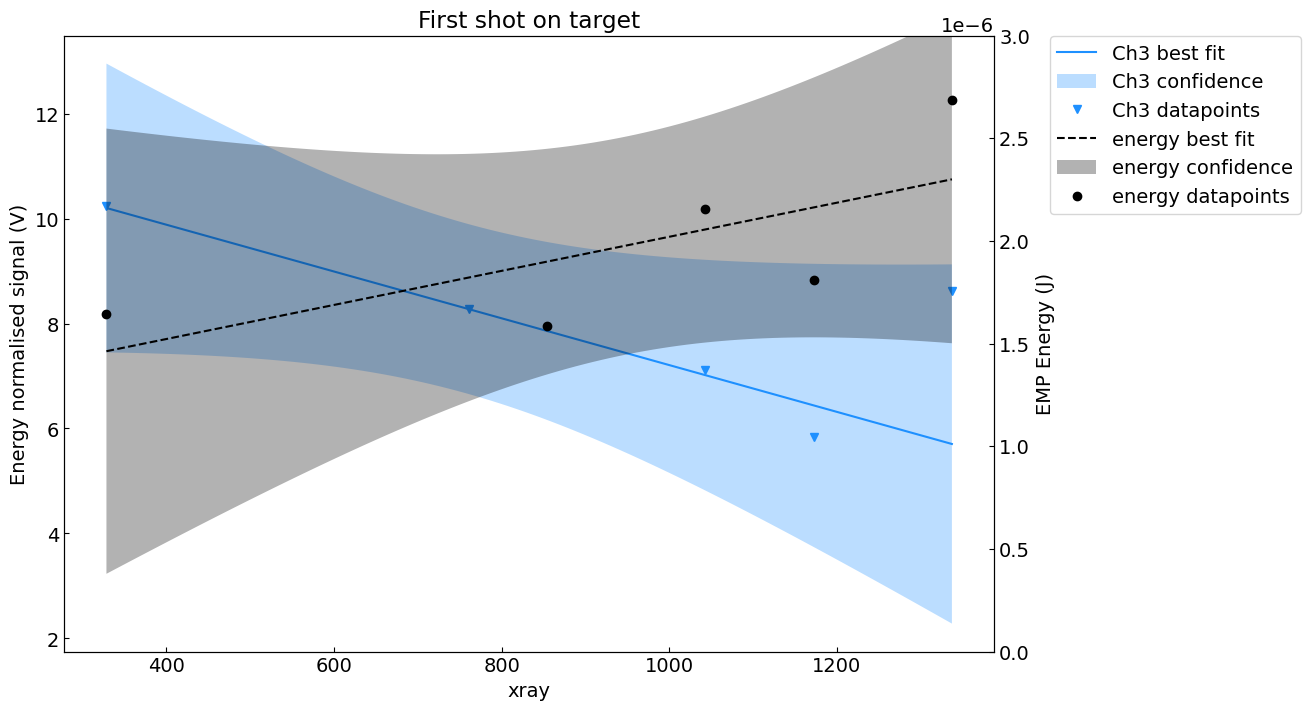

In [93]:
fig, axs = plt.subplots(1, 1, figsize= (12,8))
handles = {}

def plot_diagnostic(diagnostic, ax):
    lines= ax.plot(fit_x[diagnostic],
                   fit_y[diagnostic],
                   color= formatting[diagnostic]["colour"],
                   linestyle= formatting[diagnostic]["linestyle"],
                   label= "{0:} best fit".format(diagnostic))
    
    fills= ax.fill_between(fit_x[diagnostic],
                           fit_delta[diagnostic]['lwr_conf'],
                           fit_delta[diagnostic]['upr_conf'],
                           color= formatting[diagnostic]["colour"],
                           edgecolor= "None",
                           alpha= 0.3,
                           label= "{0:} confidence".format(diagnostic))
    
    points= ax.plot(shotsheet[xaxis],
                    shotsheet[diagnostic],
                    color= formatting[diagnostic]["colour"],
                    linestyle= "None",
                    marker= formatting[diagnostic]["marker"],
                    label= "{0:} datapoints".format(diagnostic))

    return *lines, fills, points

for diagnostic in ["Ch3"]:
    handles[diagnostic] = plot_diagnostic(diagnostic, axs)

twinax = axs.twinx() 
for diagnostic in ["energy"]:
    handles["diagnostic"] = plot_diagnostic(diagnostic, twinax)

targets = np.unique(cf.flatten_list(diagnostics.values()))
axs.set(xlabel= xaxis,
        ylabel= "Energy normalised signal (V)",
        title= "First shot on target") #. \nShots " + ", ".join(targets.astype(int).astype(str)) + ".")

twinax.set(ylabel= "EMP Energy (J)",
           ylim= (0,3e-6))

handles = cf.flatten_list(handles.values())
labels = [handle.get_label() for handle in handles]
axs.legend(handles, labels, loc= "upper right", bbox_to_anchor= (1.34, 1.015)) # loc fixes the location of the legend. 

plt.show()

In [94]:
scatter_points = pd.DataFrame(columns= [*diagnostics, "d"])
scatter_error = pd.DataFrame(columns= [*diagnostics, "d"])

scatter_points = shotsheet.groupby('nth shot on target')[[*diagnostics, "d"]].mean()
scatter_error = shotsheet.groupby('nth shot on target')[[*diagnostics, "d"]].std()

def binned_mean(y, x, function):
    means = []
    bins = np.linspace(x.min(), x.max(), 8, endpoint= True)
    for bin_min, bin_max in zip(bins[:-1], bins[1:]):
        mean = y[np.logical_and(bin_min <= x, x <= bin_max)]
        mean = function(mean)
        means = means + [mean]
    return means

#scatter_points = shotsheet[[*diagnostics, "d"]].apply(binned_mean, x= shotsheet["d"], function= np.mean) # df.apply is very fussy. be careful which function to use with it.
#scatter_error = shotsheet[[*diagnostics, "d"]].apply(binned_mean, x= shotsheet["d"], function= np.std)

scatter_points

,Ch3,Ch4,bdot,xray,energy,d
nth shot on target,,,,,,
1,8.016572,0.414053,1.02768,915.991687,0.000002,0.0


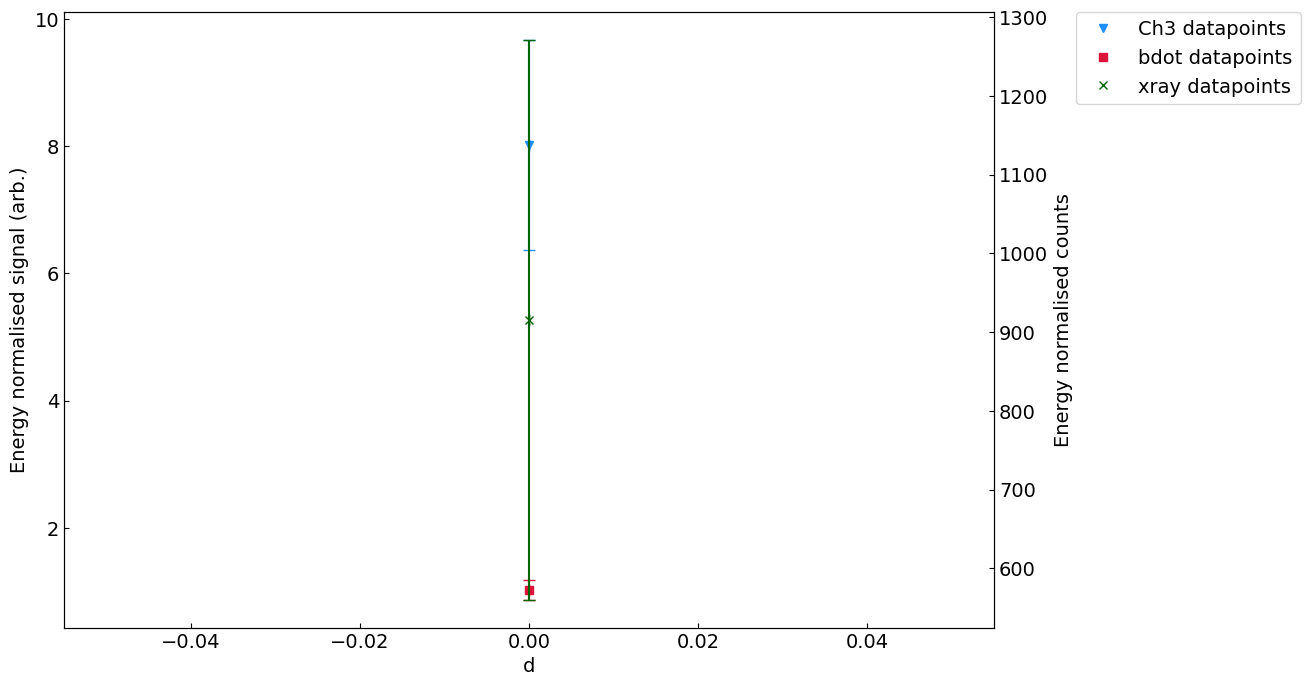

In [95]:
fig, axs = plt.subplots(1, 1, figsize= (12,8))
handles = {}

def plot_diagnostic(diagnostic, ax):
    ax.errorbar(scatter_points["d"],
                        scatter_points[diagnostic],
                        xerr= scatter_error["d"],
                        yerr= scatter_error[diagnostic],
                        color= formatting[diagnostic]["colour"],
                        linestyle= "None",
                        capsize= 4,
                        marker= formatting[diagnostic]["marker"],
                        label= "{0:} datapoints".format(diagnostic))

for diagnostic in ["Ch3","bdot"]:
    plot_diagnostic(diagnostic, axs)

twinax = axs.twinx() 
for diagnostic in ["xray"]:
    plot_diagnostic(diagnostic, twinax)

handles, labels = zip(axs.get_legend_handles_labels(), twinax.get_legend_handles_labels())

axs.set(xlabel= "d",
        ylabel= "Energy normalised signal (arb.)")
twinax.set(ylabel= "Energy normalised counts")

handles = cf.flatten_list(handles)[::7]
labels = cf.flatten_list(labels)
axs.legend(handles, labels, loc= "upper right", bbox_to_anchor= (1.34, 1.015)) # loc fixes the location of the legend. 

plt.show()

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

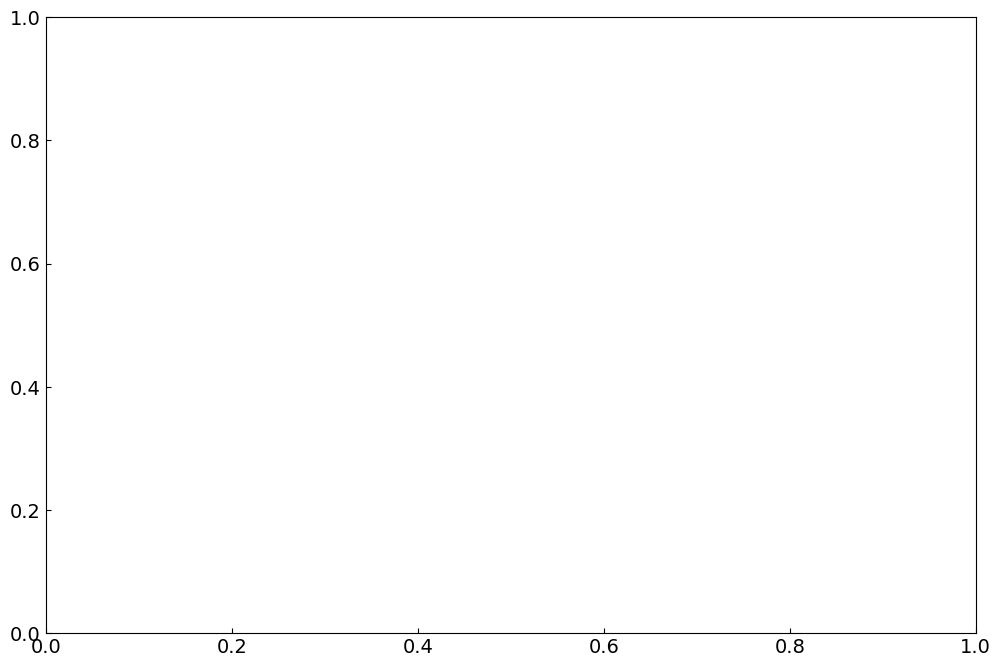

In [96]:
fig, axs = plt.subplots(1, 1, figsize= (12,8))
handles = {}

def plot_diagnostic(diagnostic, ax):
    ax.plot(shotsheet[xaxis].astype(int).astype(str),
            shotsheet[diagnostic],
            color= formatting[diagnostic]["colour"],
            linestyle= "None",
            marker= formatting[diagnostic]["marker"],
            label= "{0:} datapoints".format(diagnostic))

for diagnostic in ["Ch3","bdot"]:
    plot_diagnostic(diagnostic, axs)

twinax = axs.twinx() 
for diagnostic in ["xray"]:
    plot_diagnostic(diagnostic, twinax)

handles, labels = zip(axs.get_legend_handles_labels(), twinax.get_legend_handles_labels())

axs.set(xlabel= xaxis,
        ylabel= "Energy normalised signal (arb.)",
        title= "Eighth shots on wire")
twinax.set(ylabel= "Energy normalised counts")

fig.canvas.draw()
xticks = np.array([item.get_text() for item in axs.get_xticklabels()])
#xticks[::2] = ""
axs.set_xticklabels(xticks)

handles = cf.flatten_list(handles)
labels = cf.flatten_list(labels)
axs.legend(handles, labels, loc= "upper right", bbox_to_anchor= (1.34, 1.015)) # loc fixes the location of the legend. 

plt.show()